## Heuristic 4 - Preliminary implementation

### Description
If there are multiple (say 12) deposit transactions coming from a deposit address and later there are 12 withdraw transactions to the same withdraw address, then we can link all these deposit transactions to the withdraw transactions.

In particular, given a withdrawal transaction, an anonimity score is assigned to it:

1) The number of previous withdrawal transactions with the same address as the given withdrawal transaction is registered.

2) The deposit transactions data are grouped by their address. Addresses that deposited the same number of times as the number of withdraws registered, are grouped in a set $C$.

3) An anonimity score (of this heuristic) is assigned to the withdrawal transaction following the formula $P = 1 - 1/|C|$, where P is the anonimity score and $|C|$ is the cardinality of set $C$.

In [1]:
# Set environment variables to better visualize DataFrames.
ENV["COLUMNS"]=10000
ENV["LINES"]=10;

In [2]:
# Import relevant packages.
using DataFrames
using CSV
using StatsPlots

In [4]:
# Load withdraw and deposit data.
withdraw_transactions_df = CSV.read("../data/tornado_withdraw_df.csv", DataFrame)
deposit_transactions_df = CSV.read("../data/deposit_transactions.csv", DataFrame);

In [5]:
tornado_addresses = Dict(
    "0xd4b88df4d29f5cedd6857912842cff3b20c8cfa3" => "100 DAI",
    "0xfd8610d20aa15b7b2e3be39b396a1bc3516c7144" => "1000 DAI",
    "0x07687e702b410fa43f4cb4af7fa097918ffd2730" => "10000 DAI",
    "0x23773e65ed146a459791799d01336db287f25334" => "100000 DAI",
    "0x12d66f87a04a9e220743712ce6d9bb1b5616b8fc" => "0.1 ETH",
    "0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936" => "1 ETH",
    "0x910cbd523d972eb0a6f4cae4618ad62622b39dbf" => "10 ETH",
    "0xa160cdab225685da1d56aa342ad8841c3b53f291" => "100 ETH",
    "0xd96f2b1c14db8458374d9aca76e26c3d18364307" => "100 USDC",
    "0x4736dcf1b7a3d580672cce6e7c65cd5cc9cfba9d" => "1000 USDC",
    "0x169ad27a470d064dede56a2d3ff727986b15d52b" => "100 USDT",
    "0x0836222f2b2b24a3f36f98668ed8f0b38d1a872f" => "1000 USDT",
    "0x178169b423a011fff22b9e3f3abea13414ddd0f1" => "0.1 WBTC",
    "0x610b717796ad172b316836ac95a2ffad065ceab4" => "1 WBTC",
    "0xbb93e510bbcd0b7beb5a853875f9ec60275cf498" => "10 WBTC",
    "0x22aaa7720ddd5388a3c0a3333430953c68f1849b" => "5000 cDAI",
    "0x03893a7c7463ae47d46bc7f091665f1893656003" => "50000 cDAI",
    "0x2717c5e28cf931547b621a5dddb772ab6a35b701" => "500000 cDAI",
    "0xd21be7248e0197ee08e0c20d4a96debdac3d20af" => "5000000 cDAI"
    )    

Dict{String, String} with 19 entries:
  "0xd4b88df4d29f5cedd6857912842cff3b20c8cfa3" => "100 DAI"
  "0x07687e702b410fa43f4cb4af7fa097918ffd2730" => "10000 DAI"
  "0x22aaa7720ddd5388a3c0a3333430953c68f1849b" => "5000 cDAI"
  "0xd96f2b1c14db8458374d9aca76e26c3d18364307" => "100 USDC"
  "0xbb93e510bbcd0b7beb5a853875f9ec60275cf498" => "10 WBTC"
  ⋮                                            => ⋮

In [6]:
function compare_transactions(withdraws_dict, deposits_dict)
    for currency in keys(withdraws_dict)
        if !(deposits_dict[currency] >= withdraws_dict[currency])
            return false
        end
    end
    return true
end

compare_transactions (generic function with 1 method)

### Function summary: get_number_of_withdraws
Given a withdraw transaction and the total withdrawals data, the function get_number_of_withdraws returns the number of previous withdrawal transactions with the same address as the withdraw transaction.

In [14]:
function get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df, tornado_addresses)
    
    # The number of withdraws is initialized at 1 since the withdraw_transaction of the first argument is always present
    # in the withdrawal data. Also, the count should be 1 if there is no other transaction with the same address.
    
    n_withdraws = Dict(tornado_addresses[withdraw_transaction.to_address] => 1)
    
    # This for loop counts the number of transactions with the same address. At the end, the total number is returned.
    # The count is done considering that the recipient_address of each of the transactions in the withdraw_transactions_df
    # is the same as the recipient_address of the withdraw_transaction input, and that the timestamp of the rows is earlier
    # than the withdraw_transaction input. 
    # The if clause also filters by the transaction hash, since we don't want to count the same transaction two times.
    
    for row ∈ eachrow(withdraw_transactions_df)
        if (row.recipient_address == withdraw_transaction.recipient_address) && 
            (row.block_timestamp <= withdraw_transaction.block_timestamp) && 
            (row.hash != withdraw_transaction.hash)
            
            if haskey(n_withdraws, tornado_addresses[row.to_address])
                n_withdraws[tornado_addresses[row.to_address]] += 1
            else
                n_withdraws[tornado_addresses[row.to_address]] = 1
            end
        end
    end
    return n_withdraws
end

get_number_of_withdraws (generic function with 1 method)

In [15]:
function get_address_deposits(deposit_transactions_df, tornado_addresses)
    unique_addresses = unique(deposit_transactions_df[!, "from_address"])
    
    addresses_and_deposits_counts = combine(groupby(deposit_transactions_df, [:from_address, :to_address]), nrow => :count)
    
    addresses_and_deposit_dict = Dict()
    for row in eachrow(addresses_and_deposits_counts)
        if haskey(addresses_and_deposit_dict, row.from_address)
            if haskey(addresses_and_deposit_dict[row.from_address], tornado_addresses[row.to_address])
                addresses_and_deposit_dict[row.from_address][tornado_addresses[row.to_address]] += 1
            else
                addresses_and_deposit_dict[row.from_address][tornado_addresses[row.to_address]] = 1
            end
        else
            addresses_and_deposit_dict[row.from_address] = Dict(tornado_addresses[row.to_address] => 1)
        end
    end
    
    return addresses_and_deposit_dict
end

get_address_deposits (generic function with 1 method)

In [49]:
# test
get_address_deposits(deposit_transactions_df, tornado_addresses)

Dict{Any, Any} with 8033 entries:
  "0x50892e106095f415b4b121652a9808fe52664f82" => Dict("1 ETH"=>1, "0.1 ETH"=>1)
  "0x1dbedab746534ee35bb2cdbf970647ba2e22c898" => Dict("1 ETH"=>1)
  "0x04d473d70c0de9174d0013add877734daa7a237a" => Dict("10 ETH"=>1, "1 ETH"=>1)
  "0x96de6ffa0894aad16cc4b7e3c9e52bd8c1c02c91" => Dict("0.1 ETH"=>1)
  "0x390e817d1c8f764dd4228d67dfbe85ee5de2fbcf" => Dict("10 ETH"=>1, "100 ETH"=>1)
  ⋮                                            => ⋮

### Function summary: get_same_number_of_deposits
Given a number of withdrawal transactions, the function registers all the addresses that have made that same number of deposits. Returns an array with all the addresses that match these requirements.

In [30]:
function get_same_number_of_deposits(n_withdraws, deposit_transactions_df, tornado_addresses)
    
    # The deposits transactions data is first grouped by address, and then combined to get a new 
    # DataFrame with the addresses and their corresponding counts.
    
    address_deposits = get_address_deposits(deposit_transactions_df, tornado_addresses)
    
    return filter(address_deposit -> (Set(keys(n_withdraws))) == Set(keys(last(address_deposit))) &&
    compare_transactions(n_withdraws, last(address_deposit)),
    address_deposits) |> keys |> collect
    
    
    # The addresses are filtered by the number of counts. Only the ones that are equal or larger than the input
    # n_withdraws are returned. Finally, the output of the function is an array with the matching addresses.
    
    # return filter(row -> row.count >= n_withdraws[tornado_addresses[row.to_address]], addresses_and_deposit_counts)[!, :from_address]
end

get_same_number_of_deposits (generic function with 1 method)

In [31]:
xx = get_same_number_of_deposits(c, deposit_transactions_df, tornado_addresses)

54-element Vector{Any}:
 "0x66af9f5c9dc1f4219055f93cb8667c806b45cdcb"
 "0xb631651cb570ba0c0d696bd5e4860cbd214f20a0"
 "0xf4bbc3f8f9dae1b19da82dae46711bda90f06edd"
 ⋮
 "0xebfcef1eda60358d7e0e81db5bef89dfaaa5f3f5"
 "0xbcb7ca4ceed6730cf3d7673fd2218defbcccef6d"

In [27]:
address_deposits = get_address_deposits(deposit_transactions_df, tornado_addresses)

Dict{Any, Any} with 8033 entries:
  "0x50892e106095f415b4b121652a9808fe52664f82" => Dict("1 ETH"=>1, "0.1 ETH"=>1)
  "0x1dbedab746534ee35bb2cdbf970647ba2e22c898" => Dict("1 ETH"=>1)
  "0x04d473d70c0de9174d0013add877734daa7a237a" => Dict("10 ETH"=>1, "1 ETH"=>1)
  "0x96de6ffa0894aad16cc4b7e3c9e52bd8c1c02c91" => Dict("0.1 ETH"=>1)
  "0x390e817d1c8f764dd4228d67dfbe85ee5de2fbcf" => Dict("10 ETH"=>1, "100 ETH"=>1)
  ⋮                                            => ⋮

In [130]:
# test
a = Dict("0.1 ETH" => 4)
address_deposits = get_address_deposits(deposit_transactions_df, tornado_addresses)

filter(t_count_dict -> (Set(keys(c))) == Set(keys(last(t_count_dict))) &&
    compare_transactions(c, last(t_count_dict)),
    address_deposits)
    

Dict{Any, Any} with 54 entries:
  "0x66af9f5c9dc1f4219055f93cb8667c806b45cdcb" => Dict("10 ETH"=>1, "100 ETH"=>1, "1 ETH"=>1, "0.1 ETH"=>1)
  "0xb631651cb570ba0c0d696bd5e4860cbd214f20a0" => Dict("10 ETH"=>1, "100 ETH"=>1, "1 ETH"=>1, "0.1 ETH"=>1)
  "0xf4bbc3f8f9dae1b19da82dae46711bda90f06edd" => Dict("10 ETH"=>1, "1 ETH"=>1, "100 ETH"=>1, "0.1 ETH"=>1)
  "0x3675ec8b7188a687596b2dac921cf0932c666a03" => Dict("10 ETH"=>1, "1 ETH"=>1, "100 ETH"=>1, "0.1 ETH"=>1)
  "0xf054fb5578ebd72bc08b2ee82fcc6c56763e0839" => Dict("10 ETH"=>1, "1 ETH"=>1, "100 ETH"=>1, "0.1 ETH"=>1)
  ⋮                                            => ⋮

In [28]:
a = collect(keys(address_deposits))[803]
address_deposits[a]
c = Dict("10 ETH" => 1, "100 ETH" => 1, "1 ETH" => 1, "0.1 ETH" => 1)

Dict{String, Int64} with 4 entries:
  "10 ETH"  => 1
  "100 ETH" => 1
  "1 ETH"   => 1
  "0.1 ETH" => 1

### Function summary: get_same_number_of_deposits_heuristic
Given a withdraw_transaction and the deposit and withdraw data, compute the anonimity score of the transaction, based on this heuristic.

In [44]:
function same_number_of_deposits_heuristic(withdraw_transaction, deposit_transactions_df, withdraw_transactions_df, tornado_addresses)
    
    # We calculate the number of withdrawals of the address from the withdraw_transaction given as input.
    
    n_withdraws = get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df, tornado_addresses)
        
    # Based on n_withdraws, the set of the addresses that have the same number of deposits is calculated.
    
    Ϛ = get_same_number_of_deposits(n_withdraws, deposit_transactions_df, tornado_addresses)
    
    # The anonimity score P is computed.
    
    P = 1 - 1/length(Ϛ)
    
    # Since there is a chance that the cardinality of the set is 0, we handle this case and return the anonimity
    # score.
    
    return isinf(P) ? 1 : P
end

same_number_of_deposits_heuristic (generic function with 2 methods)

In [18]:
# Just for testing an example, we select a random withdraw_transaction
withdraw_transaction = withdraw_transactions_df[11,:]

,Column1,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,receipt_gas_used,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price,recipient_address
,Int64,String,Int64,Int64,String,String,Int64,Int64,Int64,String,Int64,Int64,Missing,Missing,Int64,String,Int64,String,Missing,Missing,Missing,Int64,String
11,10,0x3093a8c80989c31f46f7d30e7843f1518cf1546a04973cdd7f6c8d3f02a46459,6,68,0x00c975b77a640aae18d9ddfc22d87bbeaa9cc451,0x47ce0c6ed5b0ce3d3a51fdb1c52dc66a7c3c2936,0,421736,51000000000,0x21a0adb600000000000000000000000000000000000000000000000000000000000000e01f8995dcf4eae32dc1c26857780cb0e264444ba6a71827bfa56cd7f845e805e825616e2d5741a11ed8b9202ead2e0005a73aa179c6db7051ce1e7cb7e0eddcaf00000000000000000000000000c975b77a640aae18d9ddfc22d87bbeaa9cc45100000000000000000000000000c975b77a640aae18d9ddfc22d87bbeaa9cc45100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010013bcb32f17c000960572b8aa3a95a141b92931e1d0a1fa085f9ee4371262f70104434840c32bb33e4897001c70166602252046e6ddee4d55d0d058406c75b69d29b9e5266511b0ddd318a8645a0fc076b55391aec1ae22cfeba67650dac95cec05709a2094db4aca01e30e3e10c2a7d707ac0ac04bf5b52ad091f23140f9254a1efd27e2a6c86355a8c783160ffd3dfece1ed92f4454216f228cfc789684f16f12b0eb1bc5cbc69bf29692433a2ec419f801e016c33655f24ef9d2cf35efba640cf20e7fe1801d4b767cae3437c3af9fbaf487cc66c9441ec43bc4bd7403eed514adcea4d4f7187ee1c7b128fdbe125e66a5694b51ea0ca38bc366bb1ad33198,6905756,321736,missing,missing,1,2020-12-17 21:33:11 UTC,11473110,0xba9f8e7c1acb9e67be53a438a67eca7606e67aa6eb59343a625cfe0590801eac,missing,missing,missing,51000000000,0x00C975B77a640aaE18D9dDFc22d87bBeAa9CC451


In [33]:
get_number_of_withdraws(withdraw_transaction, withdraw_transactions_df, tornado_addresses)

Dict{String, Int64} with 2 entries:
  "10 ETH"   => 1
  "1000 DAI" => 4

Testing the function get_same_number_of_deposits. We can see there are 3 addresses that have done 34 deposits.


In [42]:
# test
deposits_with_same_number = combine(groupby(deposit_transactions_df, [:from_address, :to_address]), nrow => :count)
unique(deposit_transactions_df[!, "from_address"])

8033-element Vector{String}:
 "0xb050dec5a9010f8b77a3962369b7bc737d3ed4a5"
 "0x6e92bc493c6abbdd6a1b18416f003de2c873ab50"
 "0x50b9d4af009b038506d4d84b035c451d1a3a20bc"
 ⋮
 "0x20be90ebfd8395a34740db71d670d99da93b10a9"
 "0x000adf314983ca2d3ab83edb37a5517cc3af000b"

Testing same_number_of_deposits_heuristic with the withdraw_transaction we selected, computes an anonimity score to it.

In [39]:
same_number_of_deposits_heuristic(withdraw_transaction, deposit_transactions_df, withdraw_transactions_df, tornado_addresses)

Dict("10 ETH" => 2, "1 ETH" => 5, "0.1 ETH" => 1)
Any[]


1

In [41]:
function apply_same_number_of_deposits_heuristic(deposit_transactions_df, withdraw_transactions_df, tornado_addresses)
    
    # An empty dictionary is initialized. It will be used to store the anonimity score associated with each transaction.
    
    tx_hash_and_anonimity_score = Dict()
    
    # Iterate over every row of the withdraw_transactions DataFrame and apply the function same_number_of_deposits_heuristic
    # For each transaction, the anonimity score is computed and appended to the dictionary.
    
    for withdraw_row ∈ eachrow(withdraw_transactions_df)
        anonimity_score = same_number_of_deposits_heuristic(withdraw_row, deposit_transactions_df, withdraw_transactions_df, tornado_addresses)
        tx_hash_and_anonimity_score[withdraw_row.hash] = anonimity_score
    end
    
    # The dictionary with the transaction hashes and scores is returned
    
    tx_hash_and_anonimity_score
end

apply_same_number_of_deposits_heuristic (generic function with 1 method)

We apply this last function to our data and we obtain a dictionary indicating the score of each withdrawal.

In [45]:
scores = apply_same_number_of_deposits_heuristic(deposit_transactions_df, withdraw_transactions_df, tornado_addresses)


Dict{Any, Any} with 22009 entries:
  "0xe5bb17e135adbd5c381f626920779db580f4dbb4b2c8ee557df7fc17065f80d7" => 1
  "0x86cbefe25c942108732dd4aded45fa322a777f3a31c6b660343934b2cbb971d6" => 1
  "0xe02d94bb77ec0ebf35b99a3040f7d6da3dcfe3c97c728dfd9ac4d08fdc3a1394" => 1
  "0x5f863ded4ac679e4075ef59097067e96182e20ce0479390d0a5613fd10443498" => 0.994595
  "0xbbfc2bec5bb8079f8b9aff36bc18d55d0ed22fd01dccf1b28c16b8cf27351bd2" => 0.999233
  ⋮                                                                    => ⋮

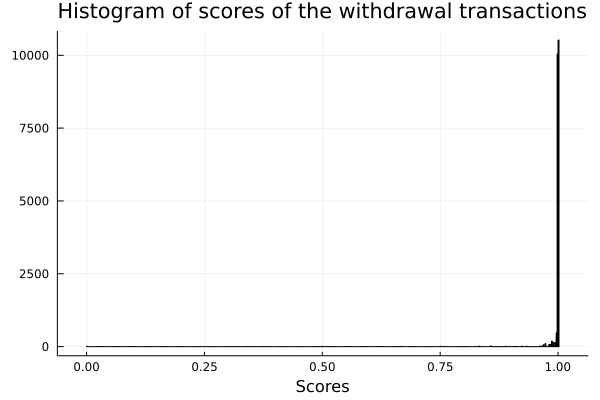

In [46]:
score_values = values(scores) |> collect
histogram(score_values, bins=500, legend=false, title="Histogram of scores of the withdrawal transactions", xlabel="Scores")